In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


In [18]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and scaler
def load_model_and_scaler(pollutant):
    model = torch.load(f'{pollutant}_model.pt')
    scaler = joblib.load(f'{pollutant}_scaler.pkl')
    data = pd.read_csv(f'update_{pollutant}.csv', parse_dates=['date'], index_col='date')
    return model, scaler, data

# Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

# Evaluate the model
def evaluate_model(model, scaler, data, lookback):
    scaled_data = scaler.transform(data)
    X, y = create_sequences(scaled_data, lookback)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X).cpu().numpy()
        actuals = y.cpu().numpy()

    # Inverse transform the predictions and actuals
    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals)
    
    return predictions, actuals

# Calculate metrics and confidence intervals
def calculate_metrics_and_intervals(predictions, actuals):
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))

    errors = actuals - predictions
    std_error = np.std(errors)
    confidence_interval = 1.96 * std_error  # For a 95% confidence interval

    lower_bound = predictions - confidence_interval
    upper_bound = predictions + confidence_interval

    return mae, rmse, lower_bound, upper_bound

# Example usage
pollutant = 'pm_25'
lookback = 300

model, scaler, data = load_model_and_scaler(pollutant)
predictions, actuals = evaluate_model(model, scaler, data, lookback)
mae, rmse, lower_bound, upper_bound = calculate_metrics_and_intervals(predictions, actuals)


In [19]:
mae, rmse, lower_bound, upper_bound 

(9.189803,
 11.71997,
 array([[ 1.1814861 ,  8.393164  ,  9.895233  , ..., 14.190485  ,
         -4.6796303 , -1.7536011 ],
        [ 0.46565247, 10.562025  ,  9.67037   , ..., 13.262289  ,
         -5.239086  , -2.3534966 ],
        [ 0.16532707, 11.940012  , 11.019636  , ..., 14.328894  ,
         -5.3362865 , -2.522295  ],
        ...,
        [ 2.0409431 ,  9.337057  , 17.74352   , ..., 21.87546   ,
         -3.8114548 , -0.49840355],
        [ 2.1020374 ,  9.013674  , 17.788866  , ..., 22.161139  ,
         -3.7103481 , -0.41780663],
        [ 2.2454014 ,  8.865772  , 18.197317  , ..., 22.756815  ,
         -3.5912514 , -0.34357643]], dtype=float32),
 array([[44.026924, 51.2386  , 52.740673, ..., 57.035927, 38.16581 ,
         41.09184 ],
        [43.311092, 53.407463, 52.51581 , ..., 56.107727, 37.606354,
         40.491943],
        [43.010765, 54.785454, 53.865074, ..., 57.17433 , 37.509155,
         40.323143],
        ...,
        [44.886383, 52.182495, 60.58896 , ..., 64.720

In [20]:
predictions, actuals

(array([[22.604206, 29.815884, 31.317953, ..., 35.613205, 16.74309 ,
         19.669119],
        [21.888372, 31.984745, 31.09309 , ..., 34.68501 , 16.183634,
         19.069223],
        [21.588047, 33.362732, 32.442356, ..., 35.751614, 16.086433,
         18.900425],
        ...,
        [23.463663, 30.759777, 39.16624 , ..., 43.29818 , 17.611265,
         20.924316],
        [23.524757, 30.436394, 39.211586, ..., 43.58386 , 17.712372,
         21.004913],
        [23.668121, 30.288492, 39.620037, ..., 44.179535, 17.831469,
         21.079144]], dtype=float32),
 array([[14.5     , 12.8     , 15.8     , ..., 19.3     , 15.3     ,
         15.8     ],
        [14.299999, 19.      , 18.999998, ..., 23.800001, 15.400001,
         16.1     ],
        [14.5     , 26.      , 23.599998, ..., 32.5     , 16.7     ,
         17.300001],
        ...,
        [21.8     , 26.      , 44.399998, ..., 62.400005, 16.2     ,
         24.9     ],
        [20.5     , 25.5     , 44.5     , ..., 57.600002,

## New expriment

In [20]:
import matplotlib.pyplot as plt

def create_aqi_legend():
    # Define the AQI ranges and their corresponding colors
    aqi_categories = ['Good', 'Moderate', 'Unhealthy for sensitive groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    colors = ['#00E400', '#FFFF00', '#FF7E00', '#FF0000', '#8F3F97', '#7E0023']

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(25, 2))
    ax.set_xlim(0, len(aqi_categories))
    ax.set_ylim(0, 2)
    ax.axis('off')  # Turn off the axis

    # Plot each AQI category with its color and name
    for i, (category, color) in enumerate(zip(aqi_categories, colors)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
        ax.text(i + 0.5, 1.5, category, color='black', ha='center', va='center', fontsize=9)

    return fig


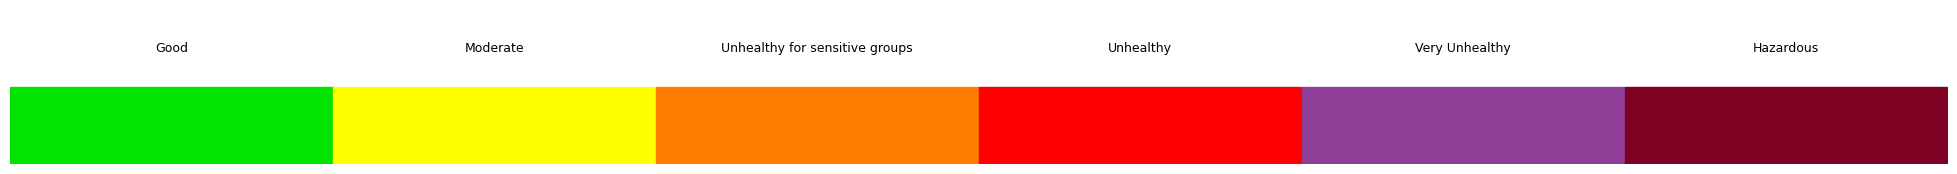

In [21]:
plot = create_aqi_legend()

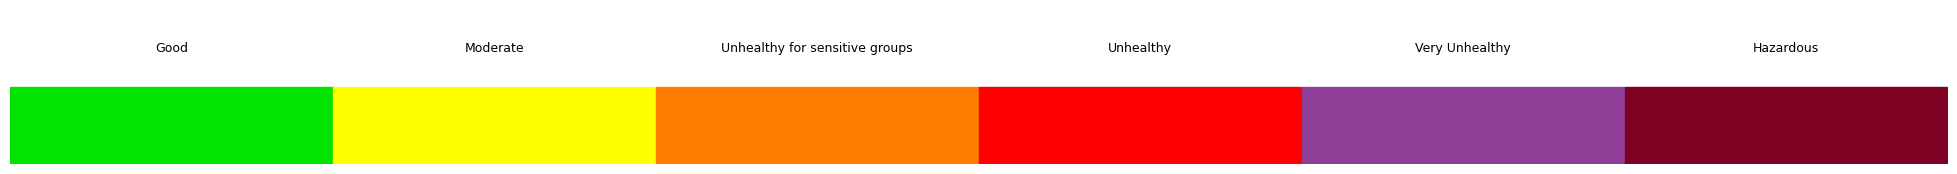

In [22]:
plot

In [1]:
import pandas as pd

def aggregate_pollutants(initial_time, district):
    forecasted_df = pd.read_csv('../New_data/forecasted_pollutant.csv')
    # replacing unnamed column with date
    forecasted_df = forecasted_df.rename(columns={'Unnamed: 0': 'date'})
    # setting the date column as index
    forecasted_df = forecasted_df.set_index('date')
    # converting the index to datetime
    forecasted_df.index = pd.to_datetime(forecasted_df.index)
    # Parse the initial time
    initial_time = pd.to_datetime(initial_time)
    final_time = initial_time + pd.Timedelta(days=14)

    # Filter the DataFrame for the specified district and time range
    filtered_df = forecasted_df[(forecasted_df.index >= initial_time) & (forecasted_df.index <= final_time) & (forecasted_df['district'] == district)]

    # Select only numeric columns for aggregation
    numeric_columns = filtered_df.select_dtypes(include=['float64', 'int64']).columns

    # Group by hour and aggregate pollutants
    aggregated_df = filtered_df[numeric_columns].resample('H').mean()
    
    return aggregated_df.drop(columns=['location_id'])

In [2]:
time = '2024-05-21 00:00:00'

In [3]:
df = aggregate_pollutants(time, 'Lahore')

C:\Users\timmy\AppData\Local\Temp\ipykernel_23872\400240702.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aggregated_df = filtered_df[numeric_columns].resample('H').mean()


In [4]:
df

,carbon_monoxide,dust,nitrogen_dioxide,ozone,pm_10,pm_25,sulphur_dioxide,AQI
date,,,,,,,,
2024-05-26 00:00:00,761.787917,72.299388,13.161848,48.373929,75.781680,20.455136,7.816162,111.446245
2024-05-26 01:00:00,753.582367,77.772163,14.493818,77.243747,75.110743,20.747499,8.036398,113.913493
2024-05-26 02:00:00,728.844233,79.817886,14.398233,138.713533,74.008538,20.722864,8.269459,117.416199
2024-05-26 03:00:00,688.312900,79.918283,14.215354,208.473923,73.600816,21.253121,8.417781,120.362158
2024-05-26 04:00:00,636.723023,79.584575,13.537659,230.460973,73.531460,21.194068,8.554648,117.265124
...,...,...,...,...,...,...,...,...
2024-06-03 20:00:00,814.286567,80.026595,18.428794,190.632977,73.832619,20.555994,8.468561,131.701617
2024-06-03 21:00:00,851.061900,80.026595,18.428791,167.138140,73.832619,20.555991,8.468561,133.029669
2024-06-03 22:00:00,873.358490,80.026595,18.428793,137.318200,73.832619,20.555991,8.468561,132.277327


In [27]:
import pandas as pd
import plotly.graph_objects as go
import streamlit as st

# Function to convert AQI to color
def aqi_to_color(aqi):
    if aqi <= 50:
        return '#00E400'  # Good
    elif aqi <= 100:
        return '#FFFF00'  # Moderate
    elif aqi <= 150:
        return '#FF7E00'  # Unhealthy for sensitive groups
    elif aqi <= 200:
        return '#FF0000'  # Unhealthy
    elif aqi <= 300:
        return '#8F3F97'  # Very Unhealthy
    else:
        return '#7E0023'  # Hazardous

# Function to create the Plotly plot
def plot_aqi_histogram(df):
    # Ensure the 'AQI' column exists in the DataFrame
    if 'AQI' not in df.columns:
        raise ValueError("The DataFrame must contain an 'AQI' column.")

    # Create the figure
    fig = go.Figure()

    # Add bars to the plot
    for i in range(len(df)):
        fig.add_trace(go.Bar(
            x=[df.index[i]],
            y=[df['AQI'].iloc[i]],
            marker_color=aqi_to_color(df['AQI'].iloc[i]),
            width=1000000,  
        ))

    # Set layout properties
    fig.update_layout(
        title='AQI Over Time',
        xaxis_title='Date and Time',
        yaxis_title='AQI',
        xaxis_tickformat='%d %b, %I %p',
        bargap=1  # Remove gaps between bars
    )

    return fig


In [28]:
plot = plot_aqi_histogram(df.iloc[:48])

In [29]:
plot

In [20]:
plot

<Figure size 1500x500 with 1 Axes>

In [32]:
def get_pollutant_values(date_hour):
    # loading the forecasted data
    forecasted_df = pd.read_csv('../New_data/forecasted_pollutant.csv')
    # replacing unnamed column with date
    forecasted_df = forecasted_df.rename(columns={'Unnamed: 0': 'date'})
    # setting the date column as index
    forecasted_df = forecasted_df.set_index('date')
    pollutant_values = forecasted_df.loc[date_hour, ['carbon_monoxide', 'dust', 'nitrogen_dioxide', 'ozone', 'pm_10', 'pm_25', 'sulphur_dioxide', 'AQI', 'district']]
    pollutant_values_agg = pollutant_values.groupby('district').mean()
    return pollutant_values_agg

date_hour = '2024-05-29 00:00:00'

pollutant_values = get_pollutant_values(date_hour)

In [33]:
pollutant_values

,carbon_monoxide,dust,nitrogen_dioxide,ozone,pm_10,pm_25,sulphur_dioxide,AQI
district,,,,,,,,
Attock,167.310622,43.020277,15.126495,35.289381,35.133671,18.312509,2.354463,38.276979
Bahawalnagar,482.910747,358.425129,15.894805,57.285008,143.495081,38.712634,6.913754,120.568360
Bahawalpur,301.512020,253.493961,6.071180,87.665889,93.176280,29.993535,6.434716,83.939092
Bhakkar,309.233660,58.957344,12.270230,51.429978,61.141953,24.792392,3.763887,62.714741
Chakwal,233.066209,51.881208,9.471811,54.154512,33.339006,17.896858,2.502805,45.796152
Chiniot,669.596480,74.616961,21.386095,25.481860,55.061126,33.498572,5.280702,99.114595
Dera Ghazi Khan,318.845797,123.971724,9.011479,75.315968,84.232479,29.822874,11.353481,76.615671
Faisalabad,724.544349,97.740134,16.732219,41.775215,61.180361,35.971139,6.665956,108.983266
Gujranwala,182.569707,63.104091,16.961721,38.416528,72.370211,19.706119,4.085951,51.225765


In [45]:
import pandas as pd
import streamlit as st

# Sample data (replace this with your actual data loading step)
data = {
    "district": ["Attock", "Bahawalnagar", "Bahawalpur", "Bhakkar", "Chakwal", "Chiniot", "Dera Ghazi Khan", "Faisalabad", "Gujranwala", "Gujrat", "Hafizabad", "Jhang", "Jhelum", "Kasur", "Khanewal", "Khushab", "Lahore", "Layyah", "Lodhran", "Mandi Bahuddin"],
    "AQI": [38.276979, 120.56836, 83.939092, 62.714741, 45.796152, 99.114595, 76.615671, 108.983266, 51.225765, 59.786822, 62.146125, 82.534053, 56.005316, 83.352872, 109.292017, 52.904439, 80.762022, 81.950843, 113.368032, 51.043177]
}

df = pd.DataFrame(data)
df = df.set_index('district')

# Function to convert AQI to color
def aqi_to_color(aqi):
    if aqi <= 50:
        return '#00E400'  # Good
    elif aqi <= 100:
        return '#FFFF00'  # Moderate
    elif aqi <= 150:
        return '#FF7E00'  # Unhealthy for sensitive groups
    elif aqi <= 200:
        return '#FF0000'  # Unhealthy
    elif aqi <= 300:
        return '#8F3F97'  # Very Unhealthy
    else:
        return '#7E0023'  # Hazardous

# Sort DataFrame by AQI in ascending order
df_sorted = df.sort_values(by='AQI', ascending=True)

# Add a column for colors based on AQI values
df_sorted['Color'] = df_sorted['AQI'].apply(aqi_to_color)

# Convert the DataFrame to a format suitable for display in Streamlit
df_display = df_sorted.reset_index()

# Streamlit app
st.title('AQI Table for Districts in Punjab, Pakistan')

# Display the table
st.write(df_display)

# Function to display the AQI table with colored AQI values
def display_colored_table(df):
    df_html = df.to_html(escape=False, index=False)
    st.markdown(df_html, unsafe_allow_html=True)

# Apply color formatting to the AQI column
df_display['AQI'] = df_display.apply(lambda row: f'<div style="background-color:{row["Color"]};">{row["AQI"]}</div>', axis=1)

# Display the colored table
display_colored_table(df_display[['district', 'AQI']])


In [46]:

display_colored_table(df_sorted)

ValueError: could not convert string to float: '<span style="color:#00E400">38.276979</span>'

In [48]:
import numpy as np
np.round(3.111117777, 3)

3.111